# Import Libraries

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.feature_selection as fs
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import normalize
import math
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import KFold
from sklearn.svm import SVC, NuSVC
from sklearn.pipeline import make_pipeline

In [2]:
data = pd.read_csv("../../../../../../Downloads/UKRiverData.csv")
print(len(data))

141431


In [3]:
weather = pd.read_csv("../../../../../../Downloads/archive.csv")
weather['time'] = pd.to_datetime(weather['time'])
len(weather)

253752

# Preprocessing

In [4]:
data = data.dropna(subset=['DO_MGL', 'NH4_N_MGL', 'PH', 'NO2_N_MGL'])

# Convert 'Date' and 'Time' columns to datetime
data['Date'] = pd.to_datetime(data['Date'])
data['Time'] = pd.to_datetime(data['Time'])

# Combine 'Date' and 'Time' columns into 'DateTime' column
data['DateTime'] = data['Date'] + pd.to_timedelta(data['Time'].dt.strftime('%H:%M:%S'))
data = data.rename(columns={'DateTime': 'time'})
data = data.drop_duplicates(subset=['time'])
data['time'] = data['time'].dt.round('H')
print(len(data))

# Remove 'Date' and 'Time' columns if no longer needed
data = data.drop(['Site_Code', 'Site_Status_21Oct2020', 'OBJECTID', 'Station_Name', 'RWB_ID_RBP2', 'FESOL1_UGL',
                  'P_SOL_MGL', 'SS_MGL','ZN_SOL_UGL', 'GlobalID','Primary_Basin', 'Depth', 'ALK_MGL', 'BOD_MGL', 
                  'COND_USCM', 'CUSOL1_MGL', 'CUSOL2_UGL', 'Date', 'Time'], axis=1)

# Combine the dataframs using merge function
weather['time'] = weather['time'].dt.tz_localize('UTC')
comb = pd.merge(data, weather, on=['time'], how='left')

# Convert our problem to a classification problem
comb['decreaseFeed'] = 1
comb.loc[comb['NH4_N_MGL'] <= 0.05, 'decreaseFeed'] = 0

# Smoothen the data
comb = comb.drop(comb[comb['NH4_N_MGL'] < 0].index)

90393


In [7]:
# Convert our problem to a classification problem
comb['decreaseFeed'] = 1
comb.loc[comb['NH4_N_MGL'] <= 0.05, 'decreaseFeed'] = 0

Index(['X', 'Y', 'DO_MGL', 'NO3_N_MGL', 'NO2_N_MGL', 'NH4_N_MGL', 'PH', 'time',
       'temperature_2m (°C)', 'relativehumidity_2m (%)', 'pressure_msl (hPa)',
       'precipitation (mm)', 'cloudcover (%)', 'direct_radiation (W/m²)',
       'diffuse_radiation (W/m²)', 'decreaseFeed'],
      dtype='object')

0.5732222222222222
0.42677777777777776


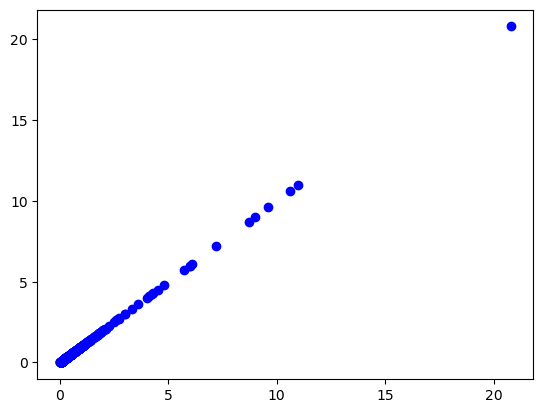

In [65]:
x = comb.sample(9000)
dec = x[x['decreaseFeed'] == 1]
print(len(dec)/9000)
man = x[x['decreaseFeed'] == 0]
print(len(man)/9000)
plt.plot(man['NH4_N_MGL'], man['NH4_N_MGL'], 'ro')
plt.plot(dec['NH4_N_MGL'], dec['NH4_N_MGL'], 'bo')
plt.show()


# Feature Selection

In [96]:
samp = comb.sample(10000)
X = samp[['DO_MGL','PH','temperature_2m (°C)', 'pressure_msl (hPa)', 'diffuse_radiation (W/m²)']].values
y = samp['decreaseFeed'].values
regressor = RandomForestClassifier(n_estimators=50)
regressor.fit(X, y)

print(regressor.feature_importances_)

[0.23896875 0.207959   0.18023651 0.19303237 0.17980338]


# Classification Methods

In [66]:
# split testset into training and tetsing
test = comb.copy(True)
X_train,X_test,y_train,y_test = train_test_split(test[['DO_MGL','PH','temperature_2m (°C)','pressure_msl (hPa)', 'diffuse_radiation (W/m²)']], 
        test['decreaseFeed'], test_size=0.2)

In [16]:
def stats(y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    tp = cm.data[0, 0]
    tn = cm.data[0, 1]
    fp = cm.data[1, 0]
    fn = cm.data[1, 1]

    print("Precision : ", tp/(tp + tn))
    print("Recall: ", tp/(tp + fp))
    print("Accuracy: ", (tp + fn)/(tp + tn + fp + fn))

    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Calculate RMSE
    mse = mean_squared_error(y_test, y_pred, squared=False)

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", math.sqrt(mse))

In [70]:
print("------ Polynomial SVC Results ------")
clf = make_pipeline(preprocessing.StandardScaler(), SVC(kernel='rbf'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

print("------ Exponential SVC Results ------")
clf = make_pipeline(preprocessing.QuantileTransformer(), SVC(kernel='poly'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

------ Polynomial SVC Results ------


In [68]:
print("------ Boosting Results ------")
model = make_pipeline(preprocessing.QuantileTransformer(), GradientBoostingClassifier(learning_rate=0.1, max_depth=3, criterion='squared_error'))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
stats(y_pred, y_test)

print("------ Bagging Results ------")
clf = make_pipeline(preprocessing.QuantileTransformer(), BaggingClassifier(n_jobs=5))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

'''
print("------ Stacking Results ------")
neural = ('nn', make_pipeline(preprocessing.SplineTransformer(), MLPClassifier(hidden_layer_sizes=(16, 32), activation='relu', max_iter=200000)))
clf = StackingClassifier(estimators=[
    ('rf', RandomForestClassifier(max_depth=24, criterion='entropy', max_features='sqrt')), 
    ('svm', SVC(kernel='rbf')),
    ('gb', GradientBoostingClassifier(max_depth=2))
    ])
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)'''

------ Boosting Results ------
[[4086 3655]
 [2097 8241]]
Precision :  0.5278387805193128
Recall:  0.660844250363901
Accuracy:  0.681840809779302
Mean Absolute Error (MAE): 0.31815919022069805
Root Mean Squared Error (RMSE): 0.7510366282128845
------ Bagging Results ------
[[4913 2828]
 [3265 7073]]
Precision :  0.634672522929854
Recall:  0.6007581315725116
Accuracy:  0.6629791470767189
Mean Absolute Error (MAE): 0.33702085292328116
Root Mean Squared Error (RMSE): 0.7619284555114592


'\nprint("------ Stacking Results ------")\nneural = (\'nn\', make_pipeline(preprocessing.SplineTransformer(), MLPClassifier(hidden_layer_sizes=(16, 32), activation=\'relu\', max_iter=200000)))\nclf = StackingClassifier(estimators=[\n    (\'rf\', RandomForestClassifier(max_depth=24, criterion=\'entropy\', max_features=\'sqrt\')), \n    (\'svm\', SVC(kernel=\'rbf\')),\n    (\'gb\', GradientBoostingClassifier(max_depth=2))\n    ])\nclf.fit(X_train, y_train)\ny_pred = clf.predict(X_test)\nstats(y_pred, y_test)'

In [69]:
print("------ KNN Results ------")
from sklearn.neighbors import KNeighborsClassifier
k = 2 
knn = KNeighborsClassifier(n_neighbors=k)
# Train the kNN classifier
knn.fit(X_train, y_train)
# Make predictions on the test set
y_pred = knn.predict(X_test)
stats(y_pred, y_test)

print("------ Decision Tree Results ------")
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=20)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
stats(y_pred, y_test)

print("------ Random Forest Results ------")
clf = RandomForestClassifier(max_depth=24, criterion='entropy', max_features='sqrt')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
stats(y_pred, y_test)

------ KNN Results ------


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


[[6231 1510]
 [4581 5757]]
Precision :  0.8049347629505232
Recall:  0.5763041065482797
Accuracy:  0.6630897726644173
Mean Absolute Error (MAE): 0.33691022733558273
Root Mean Squared Error (RMSE): 0.7618659229116868
------ Decision Tree Results ------
[[4303 3438]
 [3222 7116]]
Precision :  0.555871334452913
Recall:  0.5718272425249169
Accuracy:  0.6316167929642126
Mean Absolute Error (MAE): 0.36838320703578736
Root Mean Squared Error (RMSE): 0.7790672643536529
------ Random Forest Results ------
[[4627 3114]
 [2253 8085]]
Precision :  0.597726391939026
Recall:  0.6725290697674419
Accuracy:  0.7031362354112506
Mean Absolute Error (MAE): 0.29686376458874936
Root Mean Squared Error (RMSE): 0.7381409469231216


# Deep Learning

In [31]:
class MyDataset(Dataset):
    def __init__(self, dataframe):
        self.numeric_columns = ['DO_MGL','PH','temperature_2m (°C)', 'diffuse_radiation (W/m²)']
        self.transformer = preprocessing.QuantileTransformer()
        transformed_data = self.transformer.fit_transform(dataframe[self.numeric_columns].values)
        dataframe[self.numeric_columns] = transformed_data
        self.data = dataframe.dropna(subset=['decreaseFeed']).reset_index(drop=True)
        

    def __len__(self):
        return len(self.data)
    
    def getInverseTransform(self, inputs):
        return self.quantile_transformer.inverse_transform(inputs)

    def __getitem__(self, idx):
        inputs = self.data[self.numeric_columns].iloc[idx].values.astype(np.float32)
        label = self.data['decreaseFeed'].iloc[idx].astype(np.float32)
        inputs = torch.tensor(inputs)
        label = torch.tensor(label)
        return inputs, label

Artifical Neural Network

In [10]:
model = nn.Sequential(
    nn.Linear(4, 16),
    nn.LeakyReLU(),
    nn.Linear(16, 32),
    nn.LeakyReLU(),
    nn.Linear(32, 8),
    nn.LeakyReLU(),
    nn.Linear(8, 1),
)

Reccurrent Neural Network

In [19]:
class extract_tensor(nn.Module):
    def forward(self,x):
        # Output shape (batch, features, hidden)
        tensor, _ = x
        # Reshape shape (batch, hidden)
        return tensor[-1, :]

model = nn.Sequential(
    nn.RNN(input_size=4, hidden_size=32, num_layers=5, batch_first=True, nonlinearity="relu"),
    extract_tensor(),
    nn.CELU(),
    nn.Linear(32, 1),
)

Long Short Term Memory (LSTM)

In [29]:
model = nn.Sequential(
    nn.LSTM(input_size=4, hidden_size=16, num_layers=7 ,dropout=0.15),
    extract_tensor(),
    nn.Linear(16, 1)
)

A mix of RNN and LSTM

In [63]:
model = nn.Sequential(
    nn.LSTM(input_size=3, hidden_size=8, num_layers=3 ,dropout=0.15),
    extract_tensor(),
    nn.Linear(8, 8),
    nn.CELU(),
    nn.RNN(input_size=8, hidden_size=16, num_layers=2, batch_first=True, nonlinearity="relu"),
    extract_tensor(),
    nn.Linear(16, 1)
)

In [32]:
loss_fn = nn.SmoothL1Loss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.001)
num_epochs = 12

test = comb.copy(True)

# split testset into training and tetsing
trainset, testset = train_test_split(test, test_size=0.15)

dataset = MyDataset(trainset)
data_loader = DataLoader(dataset, drop_last=True)

print(model)
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()

    for inputs, labels in data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        
        labels = labels.view(outputs.shape)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step() 
        running_loss += abs(loss.item())

    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch {epoch+1}, Training Loss: {epoch_loss:.4f}")

Sequential(
  (0): LSTM(4, 16, num_layers=7, dropout=0.15)
  (1): extract_tensor()
  (2): Linear(in_features=16, out_features=1, bias=True)
)
Epoch 1, Training Loss: 0.1220
Epoch 2, Training Loss: 0.1137
Epoch 3, Training Loss: 0.1128
Epoch 4, Training Loss: 0.1122
Epoch 5, Training Loss: 0.1118
Epoch 6, Training Loss: 0.1113
Epoch 7, Training Loss: 0.1107
Epoch 8, Training Loss: 0.1103
Epoch 9, Training Loss: 0.1102
Epoch 10, Training Loss: 0.1099
Epoch 11, Training Loss: 0.1098
Epoch 12, Training Loss: 0.1097


In [33]:
y_test_all = []
y_pred_all = []

dataset = MyDataset(testset)
data_loader = DataLoader(dataset)

# Disable gradient calculation
with torch.no_grad():
    for inputs, label in data_loader:
        # Forward pass to get predictions
        y_pred = model(inputs.unsqueeze(1))
        if y_pred <= 0.5:
            y_pred_all.append(0)  # Append zero to the list
        else:
            y_pred_all.append(1)  # Append one to the list
        
        # Convert the predictions and targets to numpy arrays
        label_np = label.numpy()

        # Append batch results to the overall lists
        y_test_all.append(label_np)

# Concatenate the lists into a single array
y_test_all = np.array(y_test_all)
y_pred_all = np.array(y_pred_all)

stats(y_pred_all, y_test_all)

[[3427 2347]
 [2367 5418]]
Precision :  0.5935226879113267
Recall:  0.591473938557128
Accuracy:  0.6523342429382698
Mean Absolute Error (MAE): 0.3476657570617302
Root Mean Squared Error (RMSE): 0.7678749134270801
